In [1]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact
from scipy.stats import norm
from collections import Counter
from scipy.stats import binomtest
import os

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

def parse_table(i):
    return [int(x) for x in i.replace("[", "").replace("]", "").split(",")]

d_abrev = {"LiangSteinNeuron":"FC exc. neur.", "FetalChondrocytes":"F chond.", "SertoliMale":"FG sertoli", "preGC_IIaFemale":"FG preGC IIa",\
          "NeuralFemale":"FG neur.", "FetalGonadImmuneFemale":"FG immune", "VIP":"AC VIP inh. neur.", "LiangSteinProgenitor":"FC prog.",\
          "AdultHeartVentricularCardiomyocyte":"AH cardiomyo.", "AdultLoopOfHenle":"AK loop of henle", "FetalBrainNeurGlioblast_CB_VZ":"FCB glioblast",\
         "AdultProximalTubule":"AK prox. tub.", "FetalLeydigMale":"FG leydig", "SST":"AC SST inh neur.", "KosoyRoussosControlMicroglia":"AC microglia",\
         "FetalBrainFloorPlate":"FB fl. plate", "FetalArterialECs":"FH endoth.", "ASCT":"AC astro.", "FetalBrainCOP":"FB COP",\
         "AMY":"AA neur.", "PVALB":"AC PVALB inh neur.", "ITL23":"AC L2-3 IT neur.", "FetalBrainNeurCB_GNP_IPC_1":"FB inter. prog.", "FetalBrainNeurDAergic":"FB DA neur.",\
          "OGC":"AC Oligo.", "D1Pu":"AP D1 inh neur.", "FetalBrainNeurSerotonergic":"FB 5-HT neur.", "FetalBrainNeurDRG_2":"FS DRG neur.",\
          "FetalHeartPericytes":"FH peri.", "FetalHeartEndocardium":"FH endocard.", "FetalHeartCardiacFibroblasts":"FH fibro.", "FetalBrainNeurPurkinje_6":"FCB Purk. inh neur.",\
          "AdultHeartSmoothMuscle":"AH smooth musc.", "FetalBrainRoofPlate":"FB ro. plate"}

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [10]:
#Read in based on standard parameters
df = pd.DataFrame()
for file in os.listdir("IncreaseCTS"):
    if "." in file and "Swap" not in file and "FiLog" not in file:
        v = pd.read_csv("IncreaseCTS/" + file, sep = "\t")
        v = v[v["EE_Cut"] == 0.3]
        v = v[(v["ID"] == "NoChange") & (v["SpecSup447"] == 0) & (v["Proportion"] == 0.9)]
        v["Cell type"] = np.repeat(d_abrev[file.replace("_Group2", "").replace("_Group1", "").replace(".txt", "").replace("_FiLogfcEqualLogfc", "").replace("IncreaseCTS_", "").replace("_Group1", "").replace("_SwapNeur", "")], v.shape[0])
        df = pd.concat([df, v])
df = df.drop(["SpecSup447", "EE_Cut", "PhyloP447Cutoff", "Metric"], axis = 1).sort_values("Fisher exact p-value; alt greater")

In [2]:
#Make plot, remove cell types not initially analyzed
df = df[~df["Cell type"].isin(["FB DA neur.", 'AC PVALB inh neur.', 'AP D1 inh neur.', 'FCB Purk. inh neur.'])]
df["FDR"] = fdrcorrection(df["Fisher exact p-value; alt greater"])[1]

dff = df.copy()
dff["-Log$_{10}$(FDR)"] = -np.log10(dff["FDR"])

k = []
for index, row in dff.iterrows():
    if row["FDR"] < 0.05:
        k.append("FDR < 0.05")
    else:
        k.append("Not significant")
dff['Significance'] = k
fig, ax = plt.subplots(figsize = (8*0.75, 6*0.75))
sns.scatterplot(data = dff, x = "alpha", y = "-Log$_{10}$(FDR)", hue = "Significance", palette = {"FDR < 0.05":"red", "Not significant":"grey"})
plt.title("Changes in cell type-specificity of CREs", size = 18)
plt.ylabel("-Log$_{10}$(FDR)", size = 16)
plt.xlabel("$\\alpha_{CAE}$", size = 16)
plt.xticks(size = 11)
plt.yticks(size = 11)
plt.legend(fontsize = 12)



NameError: name 'df' is not defined

In [3]:
#Test across a wide range of parameters to ensure reproducibility
ranks = {}

for ee_cut in [0.2, 0.3, 0.4]:
    for cuttt in [0.6, 0.7, 0.8, 0.9, 0.95]:
        for spec_sup in [0, 250]:
            for rep in ["NoChange", "NoRepeatsNoPseudos"]:
                df = pd.DataFrame()
                for file in os.listdir("IncreaseCTS"):
                    if "." in file and "Swap" not in file and "FiLog" not in file:
                        v = pd.read_csv("IncreaseCTS/" + file, sep = "\t")
                        v = v[v["EE_Cut"] == ee_cut]
                        v = v[(v["ID"] == rep) & (v["SpecSup447"] == spec_sup) & (v["Proportion"] == cuttt) & (v["PhyloP447Cutoff"] == "NoChange")]
                        v["Cell type"] = np.repeat(d_abrev[file.replace("_Group2", "").replace("_Group1", "").replace(".txt", "").replace("_FiLogfcEqualLogfc", "").replace("_Group1", "").replace("IncreaseCTS_", "").replace("_SwapNeur", "")], v.shape[0])
                        df = pd.concat([df, v])
                df = df.sort_values("Fisher exact p-value; alt greater")
                df.index = list(range(1, df.shape[0] + 1))

                for index, row in df.iterrows():
                    if row["Cell type"] not in ranks.keys():
                        ranks[row["Cell type"]] = [index]
                    else:
                        ranks[row["Cell type"]].append(index)

Text(0.5, 1.0, 'Sensitivity analysis')

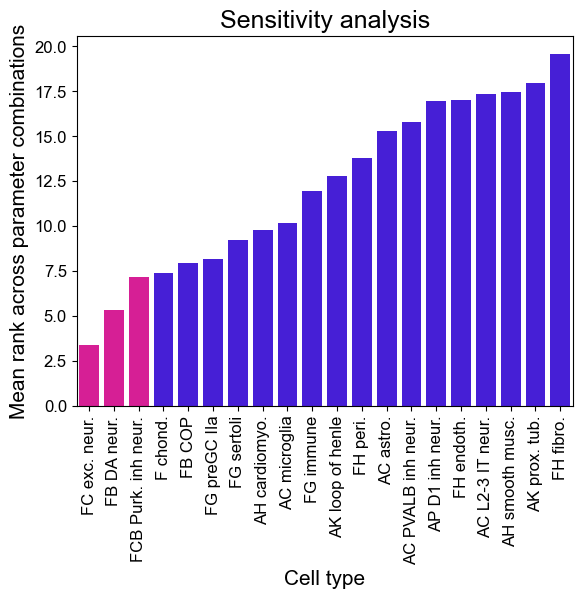

In [61]:
out = []
palette = {}
for r in ranks.keys():
    out.append([r, np.mean(ranks[r])])
    if r in ["FC exc. neur.", "FB DA neur.", "FCB Purk. inh neur."]:
        palette[r] = "#F5009E"
    else:
        palette[r] = "#3400F5"
dff = pd.DataFrame(out)
dff = dff.sort_values(1)
dff.columns = ["Cell type", "Mean rank across parameter combinations"]
sns.barplot(data = dff, x = "Cell type", y = "Mean rank across parameter combinations", hue = "Cell type", palette = palette)
plt.xticks(rotation = 90, size = 12)
plt.yticks(size = 12)
plt.xlabel("Cell type", size = 15)
plt.ylabel("Mean rank across parameter combinations", size = 15)
plt.title("Sensitivity analysis", size = 18)


In [13]:
#Making plots
v = pd.read_csv("Fixed_ITL23.txt.gz", sep = "\t")
vv = pd.read_csv("Poly_MAF0.25_ITL23.txt.gz", sep = "\t")


try:
    vv = add_unfold(vv)
    vv_ref = vv[vv["Human ref"] == vv["Chimp ref"]]
    vv_alt = vv[vv["Human alt"] == vv["Chimp ref"]]
    vv_ref["fixed logfc"] = -vv_ref["logfc"].astype(float)
    vv_alt["fixed logfc"] = vv_alt["logfc"].astype(float)
    vv = pd.concat([vv_ref, vv_alt])
except:
    pass

te_blacklist = pd.read_csv("BlacklistTE_Variants.txt", sep = "\t")
    
v = v[~v["Position"].isin(te_blacklist["Position"])]
vv = vv[~vv["Position"].isin(te_blacklist["Position"])]

v.index = v["Position"]
vv.index = vv["Position"]

In [140]:
x = pd.read_csv("hCONDELs_HAQERs_HARs/HumChp_NC_Final_Rmdup_CREs_NoHLA_HARs.bed", sep = "\t", header = None)
x

,0,1,2,3,4,5,6,7
0,chr1,3012179,3012180,chr1,3012056,3012516,HARsv2_0002,1
1,chr1,3012358,3012359,chr1,3012056,3012516,HARsv2_0002,1
2,chr1,3012455,3012456,chr1,3012056,3012516,HARsv2_0002,1
3,chr1,3012460,3012461,chr1,3012056,3012516,HARsv2_0002,1
4,chr1,3012464,3012465,chr1,3012056,3012516,HARsv2_0002,1
...,...,...,...,...,...,...,...,...
10423,chrX,150146312,150146313,chrX,150146130,150146378,HARsv2_3169,1
10424,chrX,150146351,150146352,chrX,150146130,150146378,HARsv2_3169,1
10425,chrX,153954711,153954712,chrX,153954694,153954884,HARsv2_3170,1
10426,chrX,153954714,153954715,chrX,153954694,153954884,HARsv2_3170,1


In [161]:
vh = v[v["Position"].isin(x[0] + ":" + x[2].astype(str))]
vh = vh[vh["NearestGene"].isin(["TENM3", "AKAP6", "SOCS2", "DCTD", "TBC1D5", "RHOB", "LAPTM4A", "NRSN2", "SRXN1", "PLCL2", "ARL8B", "PSMA6", "PLXNC1", "BTG1", "ARHGAP5", "BHLHE40", "NPAS3", "ONECUT2", "SCRT2", "TENM3", "BAZ1A", "AKAP6", "GLI2", "PUM2", "DAZL"])]

In [165]:
#chr18:56911122 has matching sign for ONECUT2
v[v["Position"].isin(pos)].sort_values("logfc")

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,abs logfc,EE_Allele1,EE_Allele2,EE_Dif,Fixed EE_Dif
Position,,,,,,,,,,,,,,,
chr2:21519617,chr2:21519617,chr2:21519617,TDRD15,395645,0.389,0.997,439,-0.439667,2430.36700,1791.92100,0.439667,0.466507,0.415930,0.050578,0.050578
chr2:21519609,chr2:21519609,chr2:21519609,TDRD15,395637,1.339,1.000,433,-0.430240,2428.06200,1801.95780,0.430240,0.465508,0.430851,0.034657,0.034657
chr2:21519593,chr2:21519593,chr2:21519593,TDRD15,395621,-0.225,0.189,439,-0.245194,2447.63500,2065.07470,0.245194,0.466394,0.439267,0.027127,0.027127
chr2:21519497,chr2:21519497,chr2:21519497,TDRD15,395525,2.194,1.000,441,-0.240612,2486.47660,2104.51900,0.240612,0.473633,0.456701,0.016931,0.016931
chr18:56911122,chr18:56911122,chr18:56911122,BOD1L2,235968,2.127,1.000,438,-0.212208,894.50050,772.14624,0.212208,0.188269,0.191918,-0.003649,-0.003649
chr12:94535295,chr12:94535295,chr12:94535295,CCDC41,75380,0.997,1.000,443,-0.209973,7508.23440,6491.27050,0.209973,0.336173,0.327891,0.008282,0.008282
chr2:121075379,chr2:121075379,chr2:121075379,TFCP2L1,209781,1.346,1.000,403,-0.169543,8673.25200,7711.59860,0.169543,0.319444,0.300653,0.018791,0.018791
chr18:56911123,chr18:56911123,chr18:56911123,BOD1L2,235967,2.242,0.998,438,-0.147972,894.25684,807.08325,0.147972,0.188214,0.202450,-0.014236,-0.014236
chr14:33792804,chr14:33792804,chr14:33792804,EGLN3,158265,4.373,1.000,445,-0.125976,7555.12700,6923.39650,0.125976,0.224451,0.214880,0.009571,0.009571


In [14]:
#Reading difference in CAE data, can change dl_prefix to do different cell type
dl_path = "./"
dl_prefix = "ITL23"
cts_metric = "ITL23"
cts_fixed = pd.read_csv(dl_path + dl_prefix + "_EEs_HumanDerived_WithNeuron.txt.gz", sep = "\t").set_index("Position")
cts_poly = pd.read_csv(dl_path + dl_prefix + "_EEs_Polymorphic_WithNeuron.txt.gz", sep = "\t").set_index("Position")
cts_fixed = cts_fixed[["EE_Allele1", "EE_Allele2"]]
cts_poly = cts_poly[["EE_Allele1", "EE_Allele2"]]

v = v.join(cts_fixed).dropna().drop_duplicates("Position")
vv = vv.join(cts_poly).dropna().drop_duplicates("Position")
print(v)
print(vv)

v.index = v["Position"]
vv.index = vv["Position"]

v["EE_Allele1"] = v["EE_Allele1"].astype(float)
v["EE_Allele2"] = v["EE_Allele2"].astype(float)
vv["EE_Allele1"] = vv["EE_Allele1"].astype(float)
vv["EE_Allele2"] = vv["EE_Allele2"].astype(float)

v["EE_Dif"] = v["EE_Allele1"] - v["EE_Allele2"]
vv["EE_Dif"] = vv["EE_Allele1"] - vv["EE_Allele2"]

print(v.shape[0], vv.shape[0])

v["logfc"] = v["logfc"].astype(float)
v["abs logfc"] = v["abs logfc"].astype(float)

vv["logfc"] = vv["logfc"].astype(float)
vv["fixed logfc"] = vv["fixed logfc"].astype(float)
vv["abs logfc"] = vv["abs logfc"].astype(float)

signs = []
for index, row in vv.iterrows():
    if np.sign(row["logfc"]) == np.sign(row["fixed logfc"]):
        signs.append(1)
    else:
        signs.append(-1)
vv["SignFlip"] = signs
vv["Fixed EE_Dif"] = vv["SignFlip"]*vv["EE_Dif"]
v["Fixed EE_Dif"] = v["EE_Dif"]

v = v.drop_duplicates("Position")
vv = vv.drop_duplicates("Position")


                    Position     Position.1 NearestGene  NearestDist  \
Position                                                               
chr1:15446        chr1:15446     chr1:15446       OR4F5        53644   
chr1:16497        chr1:16497     chr1:16497       OR4F5        52593   
chr1:16580        chr1:16580     chr1:16580       OR4F5        52510   
chr1:19051        chr1:19051     chr1:19051       OR4F5        50039   
chr1:39163        chr1:39163     chr1:39163       OR4F5        29927   
...                      ...            ...         ...          ...   
chrY:56878783  chrY:56878783  chrY:56878783        CDY1     31256667   
chrY:56878814  chrY:56878814  chrY:56878814        CDY1     31256698   
chrY:56884539  chrY:56884539  chrY:56884539        CDY1     31262423   
chrY:56884573  chrY:56884573  chrY:56884573        CDY1     31262457   
chrY:56884587  chrY:56884587  chrY:56884587        CDY1     31262471   

               PhyloP447  PhastCons447  SpecSup447     logfc  \

In [15]:
#Filter as done for analysis on cluster
v2 = v[(v["EE_Allele1"] > 0.3) | (v["EE_Allele2"] > 0.3)]
vv2 = vv[(vv["EE_Allele1"] > 0.3) | (vv["EE_Allele2"] > 0.3)]




C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Text(0.5, 30.722222222222207, 'Difference in CAE')

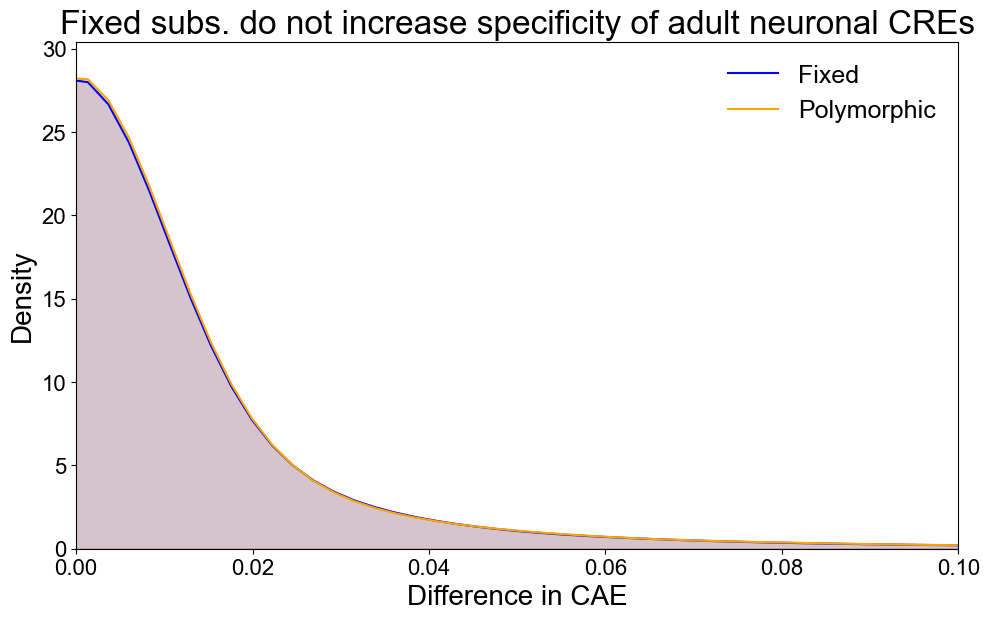

In [16]:
#Create plot
vvv = prepare_alpha(v2, vv2, stat = "Fixed EE_Dif")
cutoff = 0.01
compute_alpha_cutoff(vvv, window = [0, 0.1], plot = True, title = "Fixed subs. do not increase specificity of adult neuronal CREs")
plt.xlabel("Difference in CAE", size = 20)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

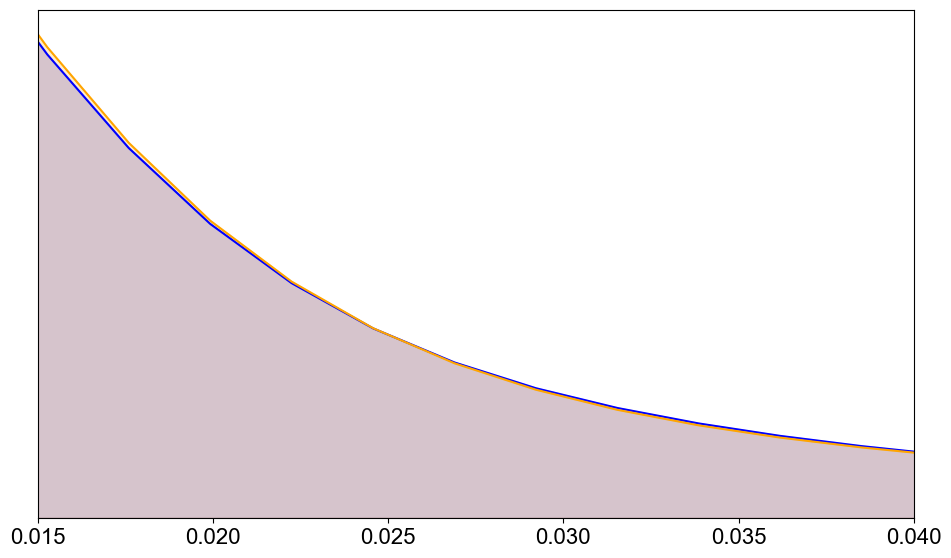

In [17]:
#Create zoomed in plot
vvv = prepare_alpha(v2, vv2, stat = "Fixed EE_Dif")
cutoff = 0.01
compute_alpha_cutoff(vvv, window = [0.015, 0.04], plot = True, title = "Fixed subs. increase specificity of fetal neuronal CREs")


plt.title("")
plt.xlabel("")
plt.ylabel("")
#plt.xticks([], [])
plt.yticks([], [])
plt.legend([], [], frameon = False)

In [207]:
np.mean(v[np.abs(v["EE_Dif"]) > 0.025]["abs logfc"])

0.39108255067586306

In [189]:
vx = v[v["NearestGene"].isin(x2["Gene"])]
vb = v[~v["NearestGene"].isin(x2["Gene"])]

vvx = vv[vv["NearestGene"].isin(x2["Gene"])]
vvb = vv[~vv["NearestGene"].isin(x2["Gene"])]

vvv = prepare_alpha(vx, vvx, stat = "abs logfc")
z = list(vvx["abs logfc"])
z.sort()
cutoff = z[int(floor((len(z)*cuttt)))]

alpha = compute_alpha_cutoff(vvv, plot = False, window = [0, 0.5], cutoff = cutoff)
plt.show()
print("Abs logfc alpha", alpha)
print("Abs logfc p-value", (fisher_exact(alpha[-1])[1] + fisher_exact(alpha[-2])[1])/2)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Abs logfc alpha (-0.005818706167627585, 0.09007286, [[17263, 156289], [4832, 43498]], [[17263, 156289], [4833, 43497]])
Abs logfc p-value 0.7344448046970071


In [187]:
vvv = prepare_alpha(vb, vvb, stat = "abs logfc")
z = list(vvb["abs logfc"])
z.sort()
cutoff = z[int(floor((len(z)*cuttt)))]

alpha = compute_alpha_cutoff(vvv, plot = False, window = [0, 0.5], cutoff = cutoff)
plt.show()
print("Abs logfc alpha", alpha)
print("Abs logfc p-value", (fisher_exact(alpha[-1])[1] + fisher_exact(alpha[-2])[1])/2)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Abs logfc alpha (-0.00275195904260217, 0.087767296, [[980715, 8850730], [271519, 2443676]], [[980716, 8850729], [271520, 2443675]])
Abs logfc p-value 0.22939002903465247


In [171]:
vs = v[(np.abs(v["EE_Dif"]) >= 0.15) & (v["NearestGene"].isin(keep))]
vb = v[(np.abs(v["EE_Dif"]) <= 0.15) & (v["NearestGene"].isin(keep))]

vsb = v[(np.abs(v["EE_Dif"]) >= 0.15)]
vbb = v[(np.abs(v["EE_Dif"]) <= 0.15)]

fisher_exact([[vs.shape[0], vb.shape[0]], [vsb.shape[0] - vs.shape[0], vbb.shape[0] - vb.shape[0]]])

SignificanceResult(statistic=1.13620693063106, pvalue=0.10365024895712849)

In [180]:
vvs = vv[(np.abs(vv["EE_Dif"]) >= 0.05) & (vv["NearestGene"].isin(keep))]
vvb = vv[(np.abs(vv["EE_Dif"]) <= 0.05) & (vv["NearestGene"].isin(keep))]

vvsb = vv[(np.abs(vv["EE_Dif"]) >= 0.05)]
vvbb = vv[(np.abs(vv["EE_Dif"]) <= 0.05)]

fisher_exact([[vvs.shape[0], vvb.shape[0]], [vvsb.shape[0] - vvs.shape[0], vvbb.shape[0] - vvb.shape[0]]])

SignificanceResult(statistic=1.1296839671746786, pvalue=0.00011652028879552672)

In [177]:
vs = v[(np.abs(v["logfc"]) >= 0.95) & (v["NearestGene"].isin(keep))]
vb = v[(np.abs(v["logfc"]) <= 0.95) & (v["NearestGene"].isin(keep))]

vsb = v[(np.abs(v["logfc"]) >= 0.95)]
vbb = v[(np.abs(v["logfc"]) <= 0.95)]

fisher_exact([[vs.shape[0], vb.shape[0]], [vsb.shape[0] - vs.shape[0], vbb.shape[0] - vb.shape[0]]])

SignificanceResult(statistic=1.023739071911213, pvalue=0.5312791539819204)

In [172]:
[[vs.shape[0], vb.shape[0]], [vsb.shape[0] - vs.shape[0], vbb.shape[0] - vb.shape[0]]]

[[199, 1555621], [954, 8473377]]

In [161]:
vs = v[(v["EE_Dif"] >= 0.1) & (v["NearestGene"].isin(keep))]
vb = v[(v["EE_Dif"] <= -0.1) & (v["NearestGene"].isin(keep))]

vsb = v[(v["EE_Dif"] >= 0.1)]
vbb = v[(v["EE_Dif"] <= -0.1)]

fisher_exact([[vs.shape[0], vb.shape[0]], [vsb.shape[0] - vs.shape[0], vbb.shape[0] - vb.shape[0]]])

SignificanceResult(statistic=0.9205125339889001, pvalue=0.30234200376782805)

In [159]:
[[vs.shape[0], vb.shape[0]], [vsb.shape[0] - vs.shape[0], vbb.shape[0] - vb.shape[0]]]

[[2254, 2483], [11459, 11447]]

In [152]:
ttest_ind(vs["abs logfc"], vb["abs logfc"])

TtestResult(statistic=1.2192950945220382, pvalue=0.22278360938412628, df=5595.0)

In [106]:
vk[vk["EE_Dif"] > 0.025].sort_values("PhyloP447")

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,abs logfc,EE_Allele1,EE_Allele2,EE_Dif,Fixed EE_Dif
Position,,,,,,,,,,,,,,,
chr2:234773234,chr2:234773234,chr2:234773234,SH3BP4,178805,-15.955,0.0,341,-0.050493,652.52990,630.08716,0.050493,0.131783,0.104194,0.027589,0.027589
chr22:40418995,chr22:40418995,chr22:40418995,SGSM3,48373,-12.647,0.0,441,0.053287,6660.35550,6910.96240,0.053287,0.353766,0.292235,0.061531,0.061531
chr20:46163862,chr20:46163862,chr20:46163862,CD40,45563,-8.391,0.0,256,-0.316385,837.31683,672.43225,0.316385,0.241644,0.204859,0.036786,0.036786
chr12:130154885,chr12:130154885,chr12:130154885,FZD10,7636,-8.221,0.0,202,-0.231270,2207.50760,1880.54220,0.231270,0.239845,0.206374,0.033470,0.033470
chr7:22352100,chr7:22352100,chr7:22352100,RAPGEF5,4988,-7.003,0.0,409,-0.427008,1308.01010,972.90125,0.427008,0.227892,0.200938,0.026954,0.026954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr2:175008896,chr2:175008896,chr2:175008896,CHN1,3614,5.869,1.0,436,-0.367723,1260.73190,977.07300,0.367723,0.332254,0.276830,0.055424,0.055424
chr2:143552462,chr2:143552462,chr2:143552462,ARHGAP15,423087,6.294,1.0,427,-0.386526,1400.72310,1071.51030,0.386526,0.257880,0.214687,0.043193,0.043193
chr7:17962880,chr7:17962880,chr7:17962880,SNX13,22388,6.997,1.0,444,-0.013547,479.18378,474.70532,0.013547,0.141013,0.111415,0.029599,0.029599


In [101]:
v2 = v[np.abs(v["EE_Dif"]) > 0.01]
vv2 = vv[np.abs(vv["EE_Dif"]) > 0.01]


['Regulation Of GTPase Activity (GO:0043087)', 9429, 2659, 1.4712052653229124, 9.181603150138087e-05]


In [83]:
ttest_ind(v[v["EE_Dif"] < -0.025]["PhyloP447"], vv[vv["Fixed EE_Dif"] < -0.025]["PhyloP447"])

TtestResult(statistic=-1.1214083142427982, pvalue=0.26211762102584146, df=76450.0)

In [94]:
float(9.181603150138087e-05)

9.181603150138087e-05

In [ ]:
0.000092

In [86]:
dff = pd.DataFrame(out)
dff = dff[(dff[1] > 500) & (dff[2] > 100)]
dff = dff.sort_values(4)
dff["FDR"] = fdrcorrection(dff[4])[1]
dff.head(50)

,0,1,2,3,4,FDR
1948,Regulation Of GTPase Activity (GO:0043087),1850,542,1.471205,0.000092,0.051509
210,Axon Guidance (GO:0007411),3100,859,1.272599,0.002026,0.396879
2640,Synapse Assembly (GO:0007416),1821,492,1.355555,0.003178,0.396879
1217,Neurotransmitter Secretion (GO:0007269),504,116,1.842105,0.003838,0.396879
277,Cell Junction Assembly (GO:0034329),2609,727,1.275192,0.004326,0.396879
1216,Neuropeptide Signaling Pathway (GO:0007218),1071,287,1.456836,0.005223,0.396879
1213,Neuron Projection Guidance (GO:0097485),2684,735,1.264995,0.005265,0.396879
1305,Peptidyl-Tyrosine Modification (GO:0018212),538,164,1.655408,0.005660,0.396879
2590,Skeletal System Development (GO:0001501),1680,479,1.323130,0.007078,0.404489
214,Axonogenesis (GO:0007409),3690,990,1.212829,0.007260,0.404489


In [70]:
dff = pd.DataFrame(out)
dff = dff[(dff[1] > 500) & (dff[2] > 100)]
dff = dff.sort_values(4)
dff["FDR"] = fdrcorrection(dff[4])[1]
dff.head(50)

,0,1,2,3,4,FDR
1948,Regulation Of GTPase Activity (GO:0043087),1850,542,1.471205,0.000092,0.051509
210,Axon Guidance (GO:0007411),3100,859,1.272599,0.002026,0.396879
2640,Synapse Assembly (GO:0007416),1821,492,1.355555,0.003178,0.396879
1217,Neurotransmitter Secretion (GO:0007269),504,116,1.842105,0.003838,0.396879
277,Cell Junction Assembly (GO:0034329),2609,727,1.275192,0.004326,0.396879
1216,Neuropeptide Signaling Pathway (GO:0007218),1071,287,1.456836,0.005223,0.396879
1213,Neuron Projection Guidance (GO:0097485),2684,735,1.264995,0.005265,0.396879
1305,Peptidyl-Tyrosine Modification (GO:0018212),538,164,1.655408,0.005660,0.396879
2590,Skeletal System Development (GO:0001501),1680,479,1.323130,0.007078,0.404489
214,Axonogenesis (GO:0007409),3690,990,1.212829,0.007260,0.404489


In [23]:
vv2 = vv[vv["NearestGene"].isin(keep_pli)]
v2 = v[v["NearestGene"].isin(keep_pli)]

upf = v2[v2["EE_Dif"] > 0.025].shape[0]
downf = v2[v2["EE_Dif"] < -0.025].shape[0]

upp = vv2[vv2["Fixed EE_Dif"] > 0.025].shape[0]
downp = vv2[vv2["Fixed EE_Dif"] < -0.025].shape[0]

print(fisher_exact([[upf, downf], [upp, downp]]))

vv2 = vv[~vv["NearestGene"].isin(keep_pli)]
v2 = v[~v["NearestGene"].isin(keep_pli)]

upf = v2[v2["EE_Dif"] > 0.025].shape[0]
downf = v2[v2["EE_Dif"] < -0.025].shape[0]

upp = vv2[vv2["Fixed EE_Dif"] > 0.025].shape[0]
downp = vv2[vv2["Fixed EE_Dif"] < -0.025].shape[0]

print(fisher_exact([[upf, downf], [upp, downp]]))

SignificanceResult(statistic=1.0418495521906708, pvalue=0.10512804686121588)
SignificanceResult(statistic=1.0575693239559696, pvalue=9.505952524822711e-05)


In [21]:
pli = pd.read_csv("gnomad.v4.1.constraint_metrics.tsv", sep = "\t")
pli = pli.dropna()
pli = pli[pli["lof.pLI"] > 0.9]
keep_pli = pli["gene"]

In [17]:
vv2 = vv[~vv["NearestGene"].isin(syngo)]
vv2 = vv2[vv2["fixed logfc"] == vv2["logfc"]]
v2 = v[~v["NearestGene"].isin(syngo)]

upf = v2[v2["EE_Dif"] > 0.025].shape[0]
downf = v2[v2["EE_Dif"] < -0.025].shape[0]

upp = vv2[vv2["Fixed EE_Dif"] > 0.025].shape[0]
downp = vv2[vv2["Fixed EE_Dif"] < -0.025].shape[0]

print(fisher_exact([[upf, downf], [upp, downp]]))

SignificanceResult(statistic=1.039795808816654, pvalue=0.07914677019689717)


In [128]:
syngo = pd.read_csv("../Cell_Type_Prop/Cell_Type_Prop/syngo_genes.csv")
keep = syngo["hgnc_symbol"]

v_big = v_big_back[v_big_back["EE_Dif"] > 0.05]
v_big_syn = v_big[v_big["NearestGene"].isin(keep)]
v_big_back_syn = v_big_back[v_big_back["NearestGene"].isin(keep)]

print(fisher_exact([[v_big_syn.shape[0], v_big.shape[0] - v_big_syn.shape[0]], [v_big_back_syn.shape[0] - v_big_syn.shape[0], v_big_back.shape[0] - v_big_back_syn.shape[0] - v_big.shape[0]]]))

SignificanceResult(statistic=1.0352304361478701, pvalue=0.18187819780298894)


In [123]:
np.mean(v_big_back["logfc"])

0.4234339901786883

In [124]:
[[v_big_syn.shape[0], v_big.shape[0]], [v_big_back_syn.shape[0], v_big_back.shape[0]]]

[[397, 2288], [13101, 84001]]

In [10]:
vr, vvr = remove_repeats(v, vv)
vr, vvr = remove_pseudos(vr, vvr)

In [25]:
vrf = vr[(vr["EE_Allele1"] > 0.3) | (vr["EE_Allele2"] > 0.3)]
vvrf = vvr[(vvr["EE_Allele1"] > 0.3) | (vvr["EE_Allele2"] > 0.3)]

In [105]:
vf = v[(v["EE_Allele1"] > 0.3) | (v["EE_Allele2"] > 0.3)]
vvf = vv[(vv["EE_Allele1"] > 0.3) | (vv["EE_Allele2"] > 0.3)]

In [ ]:
vvrf

In [ ]:
vrf["fixed logfc"] = vrf["logfc"]
vrf["rev logfc"] = -vrf["fixed logfc"]
vvrf["rev logfc"] = -vvrf["fixed logfc"]
vvv = prepare_alpha(vrf, vvrf, stat = "rev logfc")
compute_alpha_cutoff(vvv, plot = True, window = [-1, 1], cutoff = 0.25)

In [107]:
fisher_exact([[1682, 169196], [403, 48052]])

SignificanceResult(statistic=1.185338313203, pvalue=0.002086623859233679)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

(0.1563589999062649,
 0.1,
 [[1682, 169196], [403, 48052]],
 [[1682, 169196], [403, 48052]],
 <Figure size 1000x600 with 1 Axes>)

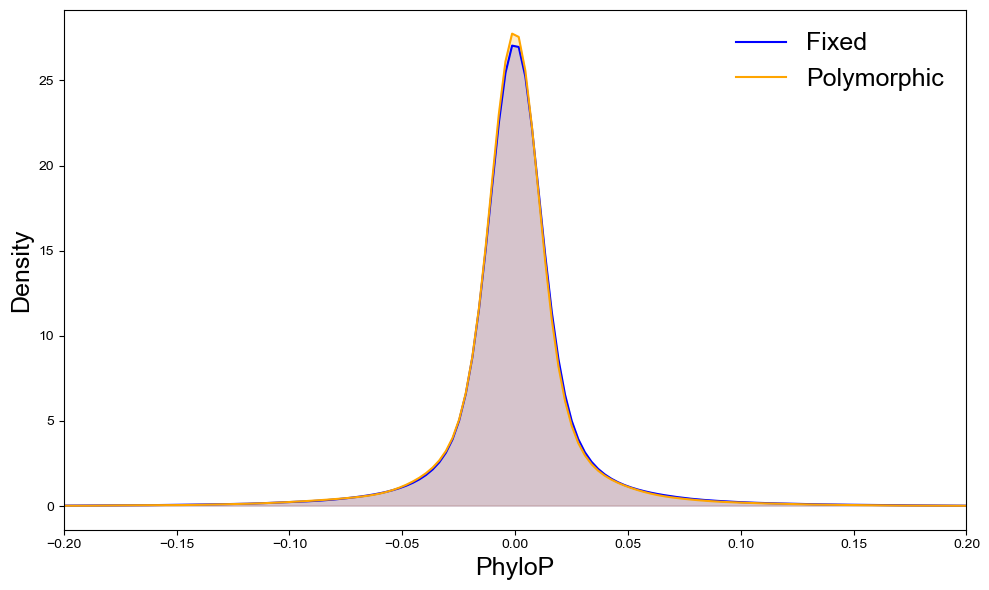

In [106]:

vvv = prepare_alpha(vf, vvf, stat = "Fixed EE_Dif")
compute_alpha_cutoff(vvv, plot = True, window = [-0.2, 0.2], cutoff = 0.1)

C:\Users\astar\AppData\Local\Temp\ipykernel_13368\3759902992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vrf["Rev EE_Dif"] = -vrf["Fixed EE_Dif"]
C:\Users\astar\AppData\Local\Temp\ipykernel_13368\3759902992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvrf["Rev EE_Dif"] = -vvrf["Fixed EE_Dif"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

(0.14277492494908406,
 0.1,
 [[1003, 114022], [239, 31695]],
 [[1003, 114022], [239, 31695]],
 <Figure size 1000x600 with 1 Axes>)

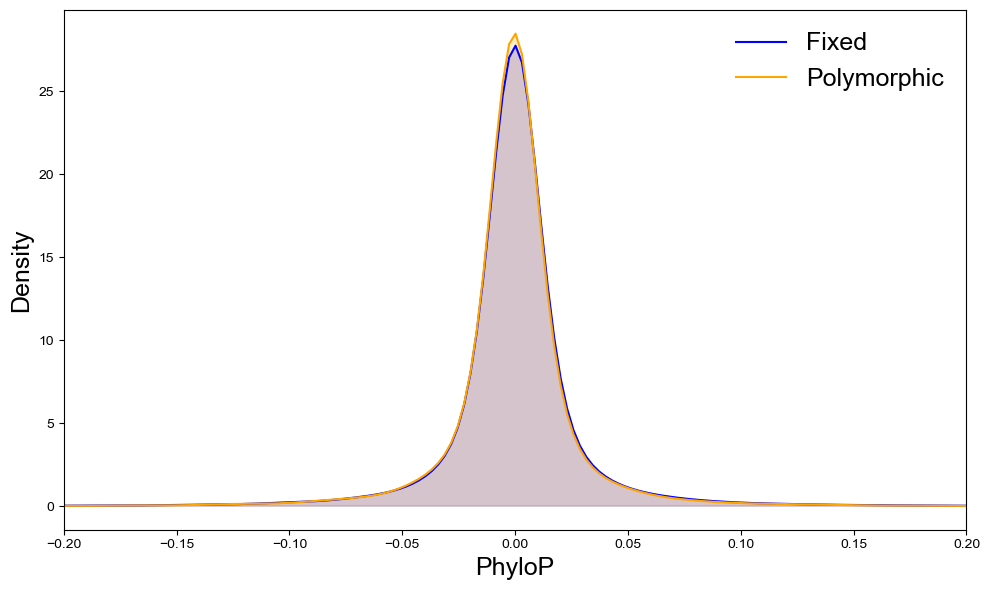

In [45]:
vrf["Rev EE_Dif"] = -vrf["Fixed EE_Dif"]
vvrf["Rev EE_Dif"] = -vvrf["Fixed EE_Dif"]

vvv = prepare_alpha(vrf, vvrf, stat = "Fixed EE_Dif")
compute_alpha_cutoff(vvv, plot = True, window = [-0.2, 0.2], cutoff = 0.1)

In [46]:
fisher_exact([[1003, 114022], [239, 31695]])

SignificanceResult(statistic=1.166554769691733, pvalue=0.03220550430419023)

In [56]:
vrf_big = vrf[vrf["Fixed EE_Dif"] > 0.025]

v2_fore = vrf_big.copy()

v2_fore["Chrom"] = [x.split(":")[0] for x in v2_fore["Position"]]
v2_fore["Pos1"] = [int(x.split(":")[1]) for x in v2_fore["Position"]]
v2_fore["Pos2"] = [int(x.split(":")[1]) + 1 for x in v2_fore["Position"]]
v2_fore = v2_fore[["Chrom", "Pos1", "Pos2"]]

#Need to change 
v2_fore.to_csv("EECut0.3_EEDif0.025_BackEEDifL0.005_Fixed_LSN_FilterNewTEs.bed", sep = "\t", header = None, index = None)

v2 = vrf.copy()

v2["Chrom"] = [x.split(":")[0] for x in v2["Position"]]
v2["Pos1"] = [int(x.split(":")[1]) for x in v2["Position"]]
v2["Pos2"] = [int(x.split(":")[1]) + 1 for x in v2["Position"]]

#Set to 0.05 for MEF2A
#Change 0.025 to 0.1 for NFIB and other TFs with large effects on CA
v2_back = pd.concat([v2_fore, v2[v2["Fixed EE_Dif"] < 0.005]])
v2_back = v2_back[["Chrom", "Pos1", "Pos2"]]
v2_back.to_csv("EECut0.3_EEDif0.025_BackEEDifL0.005_Fixed_Background_New_preGC_FilterNewTEs.bed", sep = "\t", header = None, index = None)


In [98]:
vrf_big[vrf_big["NearestGene"] == "MAT2B"]

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,...,EE_Allele2,EE_Dif,Fixed EE_Dif,Fixed logfc,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF,fixed logfc,rev logfc,Rev EE_Dif
Position,,,,,,,,,,,,,,,,,,,,,
chr5:163689752,chr5:163689752,chr5:163689752,MAT2B,184142,4.929,1.000,440,-0.588955,2311.6174,1536.81900,...,0.413848,0.102268,0.102268,-0.588955,Fixed,.,.,-0.588955,0.588955,-0.102268
chr5:164102257,chr5:164102257,chr5:164102257,MAT2B,596647,2.168,1.000,442,-0.598425,1702.3959,1124.38890,...,0.403597,0.100131,0.100131,-0.598425,Fixed,.,.,-0.598425,0.598425,-0.100131
chr5:165089355,chr5:165089355,chr5:165089355,MAT2B,1583745,-1.555,0.000,408,-0.989789,2216.8318,1116.28860,...,0.362429,0.155463,0.155463,-0.989789,Fixed,.,.,-0.989789,0.989789,-0.155463
chr5:165213869,chr5:165213869,chr5:165213869,MAT2B,1708259,1.715,0.990,190,-0.710030,1969.4094,1203.91430,...,0.507864,0.116593,0.116593,-0.710030,Fixed,.,.,-0.710030,0.710030,-0.116593
chr5:165213889,chr5:165213889,chr5:165213889,MAT2B,1708279,0.182,0.003,190,-1.044091,1945.7790,943.60657,...,0.448699,0.175536,0.175536,-1.044091,Fixed,.,.,-1.044091,1.044091,-0.175536


In [99]:
vrf_big = vrf[vrf["Fixed EE_Dif"] > 0.1]
c = Counter(vrf_big["NearestGene"])

for key in c.keys():
    if c[key] >= 4:
        print(key, c[key])

PRMT6 5
BRINP3 4
RAG2 5
KIRREL3 4
SLITRK1 4
SETMAR 4
MAT2B 5
TYRP1 4


In [91]:
vrf_big.sort_values("PhyloP447").drop(["Position.1", "MAFMaxAcrossAncestry", "UnfoldedMAF"], axis = 1).tail(50)

,Position,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,abs logfc,EE_Allele1,EE_Allele2,EE_Dif,Fixed EE_Dif,Fixed logfc,FixedOrPoly,fixed logfc,rev logfc,Rev EE_Dif
Position,,,,,,,,,,,,,,,,,,,
chr21:36893910,chr21:36893910,HLCS,72737,0.094,0.000,352,-1.657733,3535.70870,1120.59620,1.657733,0.415796,0.184643,0.231154,0.231154,-1.657733,Fixed,-1.657733,1.657733,-0.231154
chr10:11054225,chr10:11054225,CELF2,111068,0.095,0.000,424,-2.068128,922.41956,219.96820,2.068128,0.321028,0.100751,0.220276,0.220276,-2.068128,Fixed,-2.068128,2.068128,-0.220276
chr2:188346307,chr2:188346307,GULP1,53953,0.095,0.012,423,-1.565719,2688.99730,908.36840,1.565719,0.510305,0.279750,0.230554,0.230554,-1.565719,Fixed,-1.565719,1.565719,-0.230554
chrX:99250931,chrX:99250931,PCDH19,1159262,0.097,0.000,221,-1.155915,1722.52440,773.03723,1.155915,0.556436,0.356147,0.200289,0.200289,-1.155915,Fixed,-1.155915,1.155915,-0.200289
chr4:187160709,chr4:187160709,FAT1,434045,0.100,0.000,332,-1.665620,1928.70130,607.94360,1.665620,0.466115,0.255980,0.210135,0.210135,-1.665620,Fixed,-1.665620,1.665620,-0.210135
chr3:4091742,chr3:4091742,SETMAR,211637,0.105,0.000,19,-1.237708,4337.48340,1839.29110,1.237708,0.574010,0.367818,0.206192,0.206192,-1.237708,Fixed,-1.237708,1.237708,-0.206192
chr3:85519737,chr3:85519737,CADM2,560749,0.201,0.000,185,-2.133533,1149.81050,262.04080,2.133533,0.383512,0.129907,0.253605,0.253605,-2.133533,Fixed,-2.133533,2.133533,-0.253605
chr8:75859534,chr8:75859534,HNF4G,319658,0.225,0.000,417,-1.397334,2144.98730,814.30176,1.397334,0.495976,0.280093,0.215884,0.215884,-1.397334,Fixed,-1.397334,1.397334,-0.215884
chr7:91169323,chr7:91169323,FZD1,95200,0.237,0.106,443,-1.298580,3897.20600,1584.31570,1.298580,0.427508,0.226178,0.201330,0.201330,-1.298580,Fixed,-1.298580,1.298580,-0.201330


In [102]:
ra = pd.read_csv("../Prime_DB_Expression/Agoglia_Fraser_2021/STAR/Hybrid_chpr/Agoglia_Fraser_2021_DESeq2_HumChp_Hybrid_CS_D100_chpr.txt", sep = "\t")

ra = ra[ra["Gene"].isin(vrf_big["NearestGene"])].dropna()
ras = ra[ra["padj"] < 0.05]
ras[ras["log2FoldChange"]  0].shape

(24, 5)

In [70]:
syngo = pd.read_csv("../Cell_Type_Prop/Cell_Type_Prop/syngo_genes.csv")
keep = syngo["hgnc_symbol"]

vrf_big[~vrf_big["NearestGene"].isin(keep)]

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,...,EE_Allele2,EE_Dif,Fixed EE_Dif,Fixed logfc,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF,fixed logfc,rev logfc,Rev EE_Dif
Position,,,,,,,,,,,,,,,,,,,,,
chr1:858833,chr1:858833,chr1:858833,SAMD11,66903,0.138,0.000,159,-1.026756,5234.4585,2569.13840,...,0.244093,0.092595,0.092595,-1.026756,Fixed,.,.,-1.026756,1.026756,-0.092595
chr1:4101954,chr1:4101954,chr1:4101954,C1orf174,201694,0.887,0.001,345,-0.460430,3053.7139,2219.34670,...,0.261144,0.111056,0.111056,-0.460430,Fixed,.,.,-0.460430,0.460430,-0.111056
chr1:11214937,chr1:11214937,chr1:11214937,ANGPTL7,25583,-0.659,0.000,419,-2.293776,4592.4670,936.59265,...,0.199155,0.266966,0.266966,-2.293776,Fixed,.,.,-2.293776,2.293776,-0.266966
chr1:11301834,chr1:11301834,chr1:11301834,UBIAD1,28478,-2.478,0.000,408,0.074923,9115.9770,9601.90300,...,0.634535,0.065764,0.065764,0.074923,Fixed,.,.,0.074923,-0.074923,-0.065764
chr1:13949264,chr1:13949264,chr1:13949264,PRDM2,244410,0.021,0.000,423,-0.604901,2792.0964,1835.84910,...,0.291354,0.064363,0.064363,-0.604901,Fixed,.,.,-0.604901,0.604901,-0.064363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:148941625,chrX:148941625,chrX:148941625,AFF2,440898,1.222,0.000,436,-0.480557,969.7736,695.03760,...,0.298269,0.075772,0.075772,-0.480557,Fixed,.,.,-0.480557,0.480557,-0.075772
chrX:151419989,chrX:151419989,chrX:151419989,VMA21,22772,-2.934,0.000,430,-0.351104,3589.9126,2814.43430,...,0.385387,0.057798,0.057798,-0.351104,Fixed,.,.,-0.351104,0.351104,-0.057798
chrX:155166311,chrX:155166311,chrX:155166311,VBP1,50134,0.985,0.000,255,-0.314928,2685.1880,2158.59940,...,0.564351,0.050098,0.050098,-0.314928,Fixed,.,.,-0.314928,0.314928,-0.050098


In [71]:
vrf[~vrf["NearestGene"].isin(keep)]

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,...,EE_Allele2,EE_Dif,Fixed EE_Dif,Fixed logfc,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF,fixed logfc,rev logfc,Rev EE_Dif
Position,,,,,,,,,,,,,,,,,,,,,
chr1:858833,chr1:858833,chr1:858833,SAMD11,66903,0.138,0.000,159,-1.026756,5234.45850,2569.1384,...,0.244093,0.092595,0.092595,-1.026756,Fixed,.,.,-1.026756,1.026756,-0.092595
chr1:858976,chr1:858976,chr1:858976,SAMD11,66760,-1.073,0.000,173,-0.034751,3915.90040,3822.7036,...,0.316732,0.027933,0.027933,-0.034751,Fixed,.,.,-0.034751,0.034751,-0.027933
chr1:859006,chr1:859006,chr1:859006,SAMD11,66730,1.887,0.001,159,-0.015714,3600.82620,3561.8193,...,0.352675,-0.002636,-0.002636,-0.015714,Fixed,.,.,-0.015714,0.015714,0.002636
chr1:2806550,chr1:2806550,chr1:2806550,TTC34,4857,0.100,0.000,342,-0.032688,3989.96800,3900.5823,...,0.314279,-0.004568,-0.004568,-0.032688,Fixed,.,.,-0.032688,0.032688,0.004568
chr1:2806564,chr1:2806564,chr1:2806564,TTC34,4871,0.449,0.000,421,-0.109760,4086.51030,3787.1420,...,0.311034,0.003176,0.003176,-0.109760,Fixed,.,.,-0.109760,0.109760,-0.003176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:155334973,chrX:155334973,chrX:155334973,H2AFB2,45805,0.579,0.199,357,-0.067997,12795.07200,12206.0100,...,0.405255,0.006141,0.006141,-0.067997,Fixed,.,.,-0.067997,0.067997,-0.006141
chrX:155335010,chrX:155335010,chrX:155335010,H2AFB2,45768,0.584,0.015,374,0.023310,11658.37700,11848.2710,...,0.410670,-0.007906,-0.007906,0.023310,Fixed,.,.,0.023310,-0.023310,0.007906
chrX:155546253,chrX:155546253,chrX:155546253,TMLHE,66674,-0.800,0.000,281,0.099827,1680.94750,1801.3794,...,0.390874,-0.016029,-0.016029,0.099827,Fixed,.,.,0.099827,-0.099827,0.016029


In [72]:
fisher_exact([[712, 3125], [21682 - 180, 93343 - 823]])

SignificanceResult(statistic=0.9803626081294763, pvalue=0.6594537431125824)